In [11]:
print(__doc__)

import os
import time
import json
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.special import expit
from scipy import stats
from pylab import rcParams
import mplcursors

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

from sklearn.utils import check_random_state
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import linear_model
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format

Automatically created module for IPython interactive environment


In [12]:
def fetch_data_iris():
    iris = load_iris()
    X = iris.data.astype('float64')
    y = iris.target
    print ('Dataset : ', X.shape, y.shape)
    return (X, y)

def fetch_data_mnist():
    mnist = load_digits()
    X = mnist.data.astype('float64')
    y = mnist.target
    print ('Dataset : ', X.shape, y.shape)
    return (X, y)

def fetch_data_wine():
    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/winequality-white.csv", sep=';')
    df = data.iloc[:,np.r_[0:10]].copy()
    X = df.to_numpy()
    y = data.quality
    print ('df:', X.shape, y.shape)
    return (X, y)

In [13]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    def fit_predict(self, X_train, y_train, X_val, X_test):
        print ('training svm...')
        self.classifier = SVC(
            C=1, 
            kernel='linear', 
            probability=True
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class LogModel(BaseModel):

    def fit_predict(self, X_train, y_train, X_val, X_test):
        # print ('training logistic regression...')
        # train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            # C=50. / train_samples,
            penalty='l2',
            solver='newton-cg'
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    def fit_predict(self, X_train, y_train, X_val, X_test):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(
            n_estimators=100, 
            n_jobs=-1
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)



In [14]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and use the probabilities to select the most uncertain samples
    def train(self, X_train, y_train, X_val, X_test):
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)

    # we want accuracy only for the test set
    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        # print('--------------------------------')
        # print('y-test set:',y_test.shape)
        # print('Training run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate is %f " % (classif_rate))    
        # print("Classification report for %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        # print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


In [15]:
class QueryFunction(object):

    def __init__(self):
        pass

    # def stream_select(self):
    #     pass

    def pool_select(self):
        pass


class RandomSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        random_state = check_random_state(0)
        # probas_val.shape[0] is the size of validation set
        selection = np.random.choice(probas_val.shape[0], batch_size, replace=False)
        # print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',batch_size)
        return selection


class EntropySelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:batch_size]
        return selection

class MinStdSelection(QueryFunction):

    # select the samples where the std is smallest. There is uncertainty regarding the relevant class
    # and then train on these "hard" to classify samples.
    @staticmethod
    def pool_select(probas_val, batch_size):
        std = np.std(probas_val * 100, axis=1) 
        selection = std.argsort()[:batch_size]
        selection = selection.astype('int64')
        print('std',std.shape,std)
        print('selection',selection, selection.shape, std[selection])
        return selection

class LeastConfidenceSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        sort_prob = -np.sort(-probas_val, axis=1)
        values = sort_prob[:, 0]
        selection = np.argsort(values)[:batch_size]
        return selection
      
      
class MarginSelection(QueryFunction):

    @staticmethod
    def pool_select(probas_val, batch_size):
        sort_prob = -np.sort(-probas_val, axis=1)
        values = sort_prob[:, 0] - sort_prob[:, 1]
        selection = np.argsort(values)[:batch_size]
        return selection


In [16]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = RobustScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [17]:
def get_random_samples(initial_samples, X_train_full,
                         y_train_full):

    random_state = check_random_state(0)

    permutation = np.random.choice(len(X_train_full),initial_samples,replace=False)
    
    # print ()
    # print(type(permutation))
    # print ('initial random chosen samples', permutation)

    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))

    # bin_count = np.bincount(y_train.astype('int64'))
    # unique = np.unique(y_train.astype('int64'))
    # print (
    #     'initial train set:',
    #     X_train.shape,
    #     y_train.shape,
    #     'unique(labels):',
    #     bin_count,
    #     unique,
    #     )
    return (permutation, X_train, y_train)

In [18]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, step, model_object, selection_function):
        self.step = step
        self.model_object = model_object
        self.sample_selection_function = selection_function
        
# To-do: Move initiation selections as arguments
    def run(self, X_train_full, y_train_full, X_test, y_test, initial_queried, max_queried):

        # initialize process by applying base learner to labeled training data set to obtain Classifier
        (permutation, X_train, y_train) = \
            get_random_samples(initial_queried, X_train_full, y_train_full)
        self.queried = initial_queried
        # self.samplecount = [self.initiation_selections]

        # assign the val set the rest of the 'unlabelled' training data
        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        # print ('Val set:', X_val.shape, y_val.shape, permutation.shape)
        # print ()

        # normalize data
        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)
           
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # queried_num = [self.queried]

        while self.queried <= max_queried-self.step:

            active_iteration += 1
            self.queried += self.step
            # queried_num.append(self.queried)
            # get validation probabilities
            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            # print('Classifier class:', self.clf_model.model_object.classifier.classes_)
            # print('Probas_val:', probas_val)
            # pred_val = \
            #     self.clf_model.val_y_predicted
            # model_val = \
            #     self.clf_model
            # print ('val predicted:',
            #         self.clf_model.val_y_predicted.shape,
            #         self.clf_model.val_y_predicted)
            # display probability of binary value predictions of the validation set
            # print ('probas_val value', probas_val)
            # display which binary value has the highest probabilities of the validation set
            # print ('probabilities:', probas_val.shape, '\n',
            #        np.argmax(probas_val, axis=1))

            # select samples using a selection function
            uncertain_samples = self.sample_selection_function.pool_select(probas_val, self.step)

            # normalization needs to be inversed and recalculated based on the new train and test set.
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set
            # print ('trainset before adding uncertain samples', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            # print ('trainset after adding uncertain samples', X_train.shape, y_train.shape)
            # self.samplecount.append(X_train.shape[0])

            

            # bin_count = np.bincount(y_train.astype('int64'))
            # unique = np.unique(y_train.astype('int64'))
            # print (
            #     'updated train set:',
            #     X_train.shape,
            #     y_train.shape,
            #     'unique(labels):',
            #     bin_count,
            #     unique,
            #     )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            # print ('val set:', X_val.shape, y_val.shape)
            # print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            # self.queried += self.step

            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test)
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        # print('Queried numbers', queried_num)
        return self.clf_model.accuracies
        # print ('final active learning accuracies',
        #        self.clf_model.accuracies)

In [19]:
def pool_experiment(model,sampling_method,max_queried,initial_queried,step):
    (X, y) = fetch_data_mnist()
    # (X_train_full, X_test,y_train_full,  y_test) = train_test_split(X, y, test_size=0.25)
    # print(type(X_train_full))

    kf = KFold(n_splits=4)

    for train_index, test_index in kf.split(X):
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
    act_alg = TheAlgorithm(step, model , sampling_method)
    accuracies = act_alg.run(X_train_full,y_train_full,X_test,y_test,initial_queried,max_queried)

    (permutation, X_train_selected, y_train_selected) = get_random_samples(initial_queried, X_train_full, y_train_full)
    original_accuracies=[]
    classifier_original = LogisticRegression(
            # C=50. / train_samples,
            penalty='l2',
            solver='newton-cg'
            )
    x_axis = []
    for i in range(initial_queried-1,max_queried,step):
        classifier_original.fit(X_train_selected[:i+1], y_train_selected[:i+1])
        y_pred_original = classifier_original.predict(X_test)
        original_accuracies.append(accuracy_score(y_test, y_pred_original)*100)
        x_axis.append(i+1)
    print("accuracies",accuracies)
    print("nonactive_accuracies",original_accuracies)
    print("x-axis:",x_axis)
    # print("x-axis length:",len(x_axis))
    # x_axis = np.linspace(initial_queried,max_queried,num=(max_queried - initial_queried)//step +1,endpoint=True)
    plt.plot(x_axis, accuracies, 'r',label='active')
    plt.plot(x_axis, original_accuracies, 'blue',label='non-active')
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.show()

Dataset :  (1797, 64) (1797,)
--------------------------------
Iteration: 1
Accuracy rate is 28.730512 
--------------------------------
--------------------------------
Iteration: 2
Accuracy rate is 42.984410 
--------------------------------
--------------------------------
Iteration: 3
Accuracy rate is 61.692650 
--------------------------------
--------------------------------
Iteration: 4
Accuracy rate is 73.051225 
--------------------------------
--------------------------------
Iteration: 5
Accuracy rate is 76.837416 
--------------------------------
--------------------------------
Iteration: 6
Accuracy rate is 82.850780 
--------------------------------
--------------------------------
Iteration: 7
Accuracy rate is 85.523385 
--------------------------------
--------------------------------
Iteration: 8
Accuracy rate is 84.855234 
--------------------------------
--------------------------------
Iteration: 9
Accuracy rate is 84.409800 
--------------------------------
-------

ValueError: x and y must have same first dimension, but have shapes (49,) and (50,)

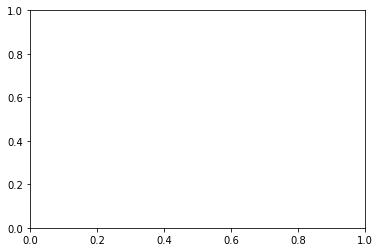

In [20]:
pool_experiment(LogModel,MarginSelection,500,10,10)